In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tqdm
import re
import librosa
from imblearn.combine import *
from sklearn import preprocessing
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from sklearn import linear_model
import scipy
from util import convertEMF
import pywt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
palette = 'deep'
sns.set(font='SimHei', font_scale=1.2, palette=palette)  # 解决Seaborn中文显示问题

In [37]:
df = pd.read_csv('../数据/population.csv')
df

,Country name,Year,Population,Population of children under the age of 1,Population of children under the age of 5,Population of children under the age of 15,Population under the age of 25,Population aged 15 to 64 years,Population older than 15 years,Population older than 18 years,...,Population aged 15 to 19 years,Population aged 20 to 29 years,Population aged 30 to 39 years,Population aged 40 to 49 years,Population aged 50 to 59 years,Population aged 60 to 69 years,Population aged 70 to 79 years,Population aged 80 to 89 years,Population aged 90 to 99 years,Population older than 100 years
0,Afghanistan,1950,7480464,301735.0,1248282,3068855,4494349,4198587,4411609,3946595,...,757113,1241348,909953,661807,467170,271905,92691,9499,123,0.0
1,Afghanistan,1951,7571542,299368.0,1246857,3105444,4552138,4250002,4466098,3993640,...,768616,1260904,922765,667015,468881,273286,94358,10155,118,0.0
2,Afghanistan,1952,7667534,305393.0,1248220,3145070,4613604,4303436,4522464,4041439,...,781411,1280288,935638,672491,470898,274852,96026,10721,139,0.0
3,Afghanistan,1953,7764549,311574.0,1254725,3186382,4676232,4356242,4578167,4088379,...,794308,1298803,948321,678064,472969,276577,97705,11254,166,0.0
4,Afghanistan,1954,7864289,317584.0,1267817,3231060,4741371,4408474,4633229,4136116,...,806216,1316768,961484,684153,475117,278210,99298,11793,190,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18067,Zimbabwe,2017,14751101,464521.0,2287404,6217928,9224369,8056253,8532951,7476399,...,1690993,2422873,2021973,1088878,570769,467775,200927,59789,8974,222.0
18068,Zimbabwe,2018,15052191,466524.0,2283576,6291632,9385132,8264833,8760331,7689502,...,1732035,2474502,2058928,1155537,585529,476214,208587,59700,9299,228.0
18069,Zimbabwe,2019,15354606,468844.0,2281740,6367398,9543409,8473475,8986973,7909270,...,1759205,2546398,2085636,1220993,606266,479827,218763,60339,9546,235.0
18070,Zimbabwe,2020,15669663,470340.0,2287105,6449021,9709135,8691594,9220402,8139472,...,1776240,2640150,2101852,1291333,631541,476507,231604,61546,9629,240.0


In [38]:
delList = pd.read_excel('../数据/Country分类.xlsx')['合计'].drop_duplicates().values
print('delList', len(delList), delList)
df = df[~df['Country name'].isin(delList)]
df

delList 19 ['Asia (UN)' 'High-income countries'
 'Land-locked developing countries (LLDC)' 'Least developed countries'
 'Less developed regions' 'Less developed regions, excluding China'
 'Less developed regions, excluding least developed countries'
 'Low-income countries' 'Lower-middle-income countries'
 'More developed regions' 'Small island developing states (SIDS)'
 'Upper-middle-income countries' 'Africa (UN)' 'World' nan 'Europe (UN)'
 'Latin America and the Caribbean (UN)' 'Northern America (UN)'
 'Oceania (UN)']


,Country name,Year,Population,Population of children under the age of 1,Population of children under the age of 5,Population of children under the age of 15,Population under the age of 25,Population aged 15 to 64 years,Population older than 15 years,Population older than 18 years,...,Population aged 15 to 19 years,Population aged 20 to 29 years,Population aged 30 to 39 years,Population aged 40 to 49 years,Population aged 50 to 59 years,Population aged 60 to 69 years,Population aged 70 to 79 years,Population aged 80 to 89 years,Population aged 90 to 99 years,Population older than 100 years
0,Afghanistan,1950,7480464,301735.0,1248282,3068855,4494349,4198587,4411609,3946595,...,757113,1241348,909953,661807,467170,271905,92691,9499,123,0.0
1,Afghanistan,1951,7571542,299368.0,1246857,3105444,4552138,4250002,4466098,3993640,...,768616,1260904,922765,667015,468881,273286,94358,10155,118,0.0
2,Afghanistan,1952,7667534,305393.0,1248220,3145070,4613604,4303436,4522464,4041439,...,781411,1280288,935638,672491,470898,274852,96026,10721,139,0.0
3,Afghanistan,1953,7764549,311574.0,1254725,3186382,4676232,4356242,4578167,4088379,...,794308,1298803,948321,678064,472969,276577,97705,11254,166,0.0
4,Afghanistan,1954,7864289,317584.0,1267817,3231060,4741371,4408474,4633229,4136116,...,806216,1316768,961484,684153,475117,278210,99298,11793,190,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18067,Zimbabwe,2017,14751101,464521.0,2287404,6217928,9224369,8056253,8532951,7476399,...,1690993,2422873,2021973,1088878,570769,467775,200927,59789,8974,222.0
18068,Zimbabwe,2018,15052191,466524.0,2283576,6291632,9385132,8264833,8760331,7689502,...,1732035,2474502,2058928,1155537,585529,476214,208587,59700,9299,228.0
18069,Zimbabwe,2019,15354606,468844.0,2281740,6367398,9543409,8473475,8986973,7909270,...,1759205,2546398,2085636,1220993,606266,479827,218763,60339,9546,235.0
18070,Zimbabwe,2020,15669663,470340.0,2287105,6449021,9709135,8691594,9220402,8139472,...,1776240,2640150,2101852,1291333,631541,476507,231604,61546,9629,240.0


# 绘制不同国家总人口数的柱状图

In [39]:
pop21Df = df[df['Year'] == 2021]
pop21Df = pop21Df.sort_values(by='Population', ascending=False)
pop21Df

,Country name,Year,Population,Population of children under the age of 1,Population of children under the age of 5,Population of children under the age of 15,Population under the age of 25,Population aged 15 to 64 years,Population older than 15 years,Population older than 18 years,...,Population aged 15 to 19 years,Population aged 20 to 29 years,Population aged 30 to 39 years,Population aged 40 to 49 years,Population aged 50 to 59 years,Population aged 60 to 69 years,Population aged 70 to 79 years,Population aged 80 to 89 years,Population aged 90 to 99 years,Population older than 100 years
3239,China,2021,1425893500,11501936.0,74789700,251927890,412677800,986464100,1173924600,1125760900,...,79508270,174028860,229977170,204141890,228613400,144414740,80093240,29252108,3894913,40972.0
7127,India,2021,1407563900,22600596.0,115307420,361569250,616154900,950245570,1045955200,969360640,...,128411740,246912060,218841600,174184980,131806584,89232770,41709948,13179305,1676180,39419.0
17135,United States,2021,336997630,3689268.0,19164416,61478596,105543540,219311550,275429280,262172960,...,22044984,44924330,45928188,41901384,43182440,40098816,24621928,10395926,2331305,89739.0
7199,Indonesia,2021,273753180,4435250.0,22414316,69742696,113864904,185451040,204008940,190564110,...,22219920,43068230,41442532,38094030,29965912,18151532,8300174,2572599,194014,1551.0
12455,Pakistan,2021,231402110,6093068.0,29604480,85480180,132265440,136153500,145921920,130864504,...,24780090,40973668,29858060,19991928,14845653,9795500,4483004,1133332,60678,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13679,Saint Helena,2021,5428,42.0,221,758,1124,3219,4669,4535,...,198,421,532,629,941,898,756,247,47,1.0
10871,Montserrat,2021,4438,41.0,196,595,1243,3077,3843,3668,...,299,633,490,610,756,574,364,108,9,0.0
5183,Falkland Islands,2021,3786,43.0,212,672,1083,2703,3114,2977,...,217,416,556,658,633,348,174,101,11,0.0
11879,Niue,2021,1957,27.0,145,514,720,1148,1443,1350,...,131,176,222,286,208,235,114,70,1,0.0


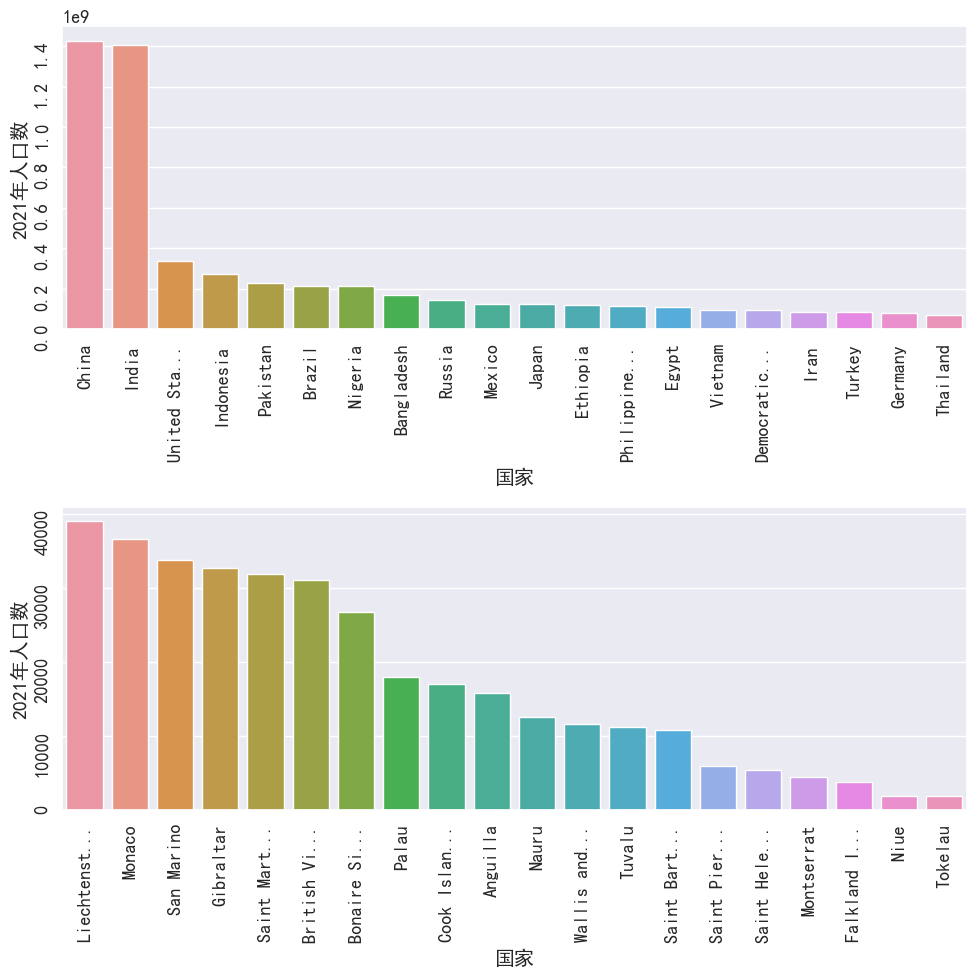

总人口最多的前 10 个国家 ['China' 'India' 'United States' 'Indonesia' 'Pakistan' 'Brazil' 'Nigeria'
 'Bangladesh' 'Russia' 'Mexico']
最少的后 10 个国家 ['Nauru' 'Wallis and Futuna' 'Tuvalu' 'Saint Barthelemy'
 'Saint Pierre and Miquelon' 'Saint Helena' 'Montserrat'
 'Falkland Islands' 'Niue' 'Tokelau']


In [40]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for idx, data in enumerate([pop21Df.head(20), pop21Df.tail(20)]):
    ax = axs[idx]
    sns.barplot(data, x='Country name', y='Population', ax=ax)

    maxLen = 10
    ticklabels = [label[:maxLen] + '...' if len(label) > maxLen else label for label in data['Country name']]
    ax.set_xticklabels(ticklabels)
    ax.tick_params(rotation=90)
    ax.set_ylabel('2021年人口数')
    ax.set_xlabel('国家')

plt.tight_layout()
convertEMF.exportEmf('人口柱状图')
plt.show()

print('总人口最多的前 10 个国家',pop21Df.head(10)['Country name'].values)
print('最少的后 10 个国家',pop21Df.tail(10)['Country name'].values)